# Udacity Capstone Project
## Supervised Learning
## 3D Point Cloud Data Classification

## Introduction
The purpose of this project is to classify points within a 3D point cloud. In particular, this project aims to identify points that are linear / pipe-like. 

The 3D point cloud data is stored in one / many files named foo.flt5.ply. The foo.flt5.ply file contains a series of (x,y,z,intensity) point cloud points from a scan of a scene that contains walls, floor, other objects and the linear/pipe-like object we are interested in. 

For the classifier, this project uses supervised learning. In the training data, points representing the pipe-like object are hand segmented. The points representing the pipe-like object are stored in a file foo-Linear.ply.

This project is an extension of the supervised learning project in Udacity's Machine Learning Engineering nanodegree.

### Inputs
1) One or more Point cloud files

file1.flt5.ply

file2.flt5.ply

file3.flt5.ply

2) Training data: One or more files contain the hand segmented points defining the pipe-like object from different scans

file1-Linear.ply

file2-Linear.ply

### Outputs
1) Ply files with the output of the trained classifier

file1.trn.ply

file2.trn.ply

2) Ply files with the output of the classifier on the untrained files

file3.tst.ply


## Loading the Data
Run the code cell below to load necessary Python libraries and load the 3D point cloud data. This section loads the full point cloud file (foo.flt5.ply), the file containing the hand-segmented points (foo-Linear.ply) Note that the last column from this dataset, `'class_id'`, is the target label.

In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import processPly as pc
import matplotlib.pyplot as plt
%matplotlib inline

data_file_path = "../data/stationary/"

(point_cloud_points, data, point_cloud_file_names) = pc.load_all_training_data(data_file_path)

print 'Data Successfully Loaded'


Training Data Files:
Point Cloud Files:
['1488571046.526833.flt5.ply']
Hand Segmented File Names
['1488571046.526833-Linear.ply']
Data Successfully Loaded


### Implementation: Data Exploration
In this section, the data is explored manually. Plots and statistics are generated to get a feel for how the data is behaving.

In [2]:
import itertools
def scatterplot_matrix_classId(data0, data1, loglog=False, filter_percentile=False, **kwargs):
    """
    Adapted from http://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Data in the data0 are plotted as blue dots
    Data in the data1 are plotted as red dots. 

    Parameters
    -------------------
    data0: pd.DataFrame
        data for class 0 objects

    data1: pd.DataFrame
        data for class 1 objects
        
    loglog: Bool
        True to plot as log log
        
    filter_percentile: Bool
        True to filter only data in 25-75 percentile
        
    kwargs
        plotting arguments

    Return Values
    -------------------
    fig: 
        Returns the matplotlib figure object containg the subplot grid.

    """
    names = data0.columns
    numvars = len(names)
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            var1 = data0.columns[x]
            var2 = data0.columns[y]
            axes[x,y].plot(data0[var1], data0[var2], 'b.', **kwargs)
            axes[x,y].plot(data1[var1], data1[var2], 'r.', **kwargs)
            if loglog:
                axes[x,y].set_yscale('log')
                axes[x,y].set_xscale('log')
            if filter_percentile:
                xval = np.concatenate((np.array(data0[var1]),np.array(data1[var1])))
                yval = np.concatenate((np.array(data0[var2]),np.array(data1[var2])))
                axes[x,y].set_xlim([np.percentile(xval,25), np.percentile(xval,75)])
                axes[x,y].set_ylim([np.percentile(yval,25), np.percentile(yval,75)])


    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig



### Raw Data Statistics

In [3]:
print 'Class 0 (Other) Data Decscription'
print(data[data['class_id']==0][data.columns[:-1]].describe())

print 'Class 1 (Target) Data Description'
print(data[data['class_id']==1][data.columns[:-1]].describe())


Class 0 (Other) Data Decscription
          pointness   surfaceness    linearness   cos_tangent   sin_tangent  \
count  1.479400e+04  14794.000000  1.479400e+04  14794.000000  14794.000000   
mean   1.094056e-04      0.000614  4.707240e-04      0.222240      0.150595   
std    3.023028e-04      0.001393  2.813322e-03      0.303284      0.342776   
min    3.677823e-07      0.000014  8.434865e-07      0.000452     -0.997971   
25%    7.722005e-06      0.000443  3.924678e-05      0.039213      0.015550   
50%    9.385035e-06      0.000496  7.374171e-05      0.083733      0.056246   
75%    5.913376e-05      0.000581  4.288475e-04      0.217159      0.158304   
max    2.007596e-02      0.120747  1.641628e-01      1.000000      0.999999   

         cos_normal    sin_normal  
count  14794.000000  14794.000000  
mean       0.865914      0.010645  
std        0.247973      0.200242  
min        0.001863     -0.998708  
25%        0.887621     -0.046560  
50%        0.993344      0.063703  
75

### Exploratory Visualization

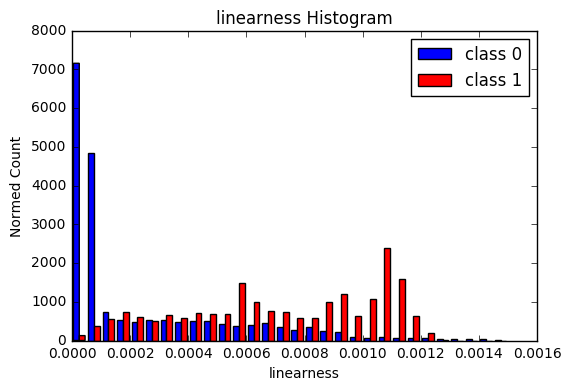

In [4]:
feature='linearness'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 0.0015], normed=True, label=['class 0', 'class 1'], bins=30)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')


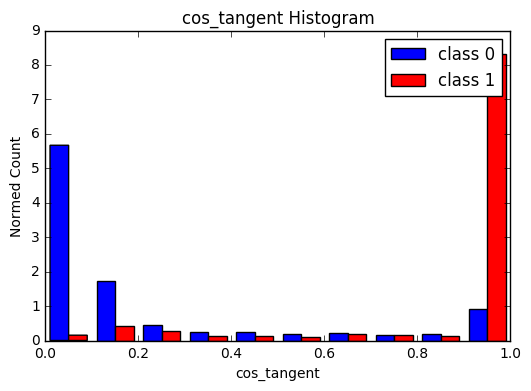

In [5]:
feature='cos_tangent'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 1.0], normed=True, label=['class 0', 'class 1'], bins=10)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')

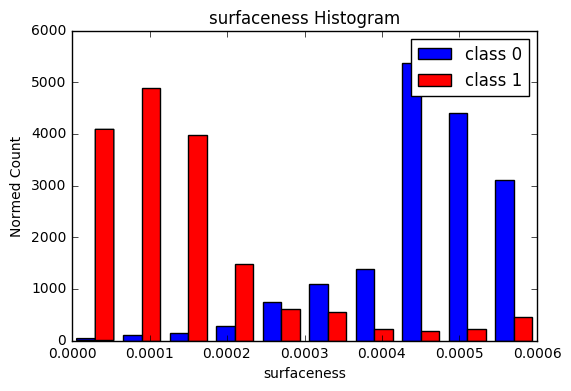

In [6]:
feature='surfaceness'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 0.0006], normed=True, label=['class 0', 'class 1'], bins=10)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')

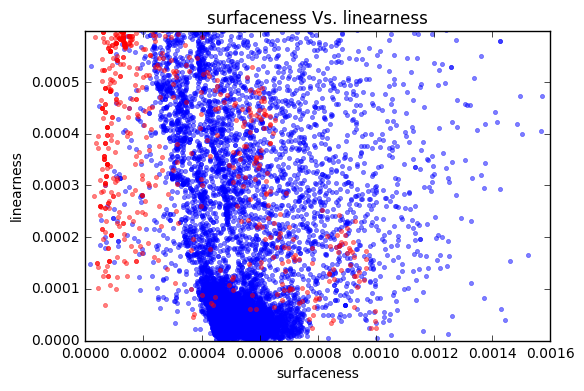

In [7]:
feature1 = 'surfaceness'
feature2 = 'linearness'
d0x = data[data['class_id']==0][feature1]
d0y = data[data['class_id']==0][feature2]
d1x = data[data['class_id']==1][feature1]
d1y = data[data['class_id']==1][feature2]
plt.plot(d0x, d0y, 'b.', alpha=0.5)
plt.plot(d1x, d1y, 'r.', alpha=0.5)
plt.gca().set_ylim([0,0.0006])
plt.gca().set_xlim([0, 0.0016])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(feature1 + ' Vs. ' + feature2)

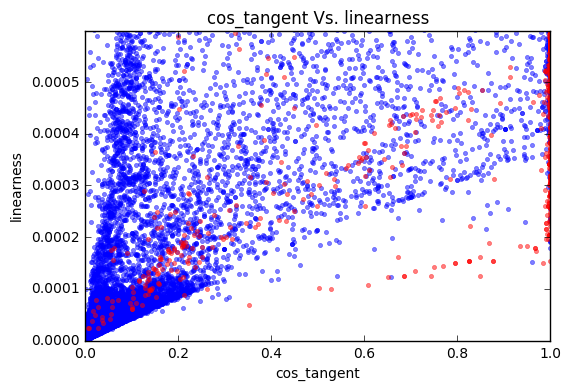

In [8]:
feature1 = 'cos_tangent'
feature2 = 'linearness'
d0x = data[data['class_id']==0][feature1]
d0y = data[data['class_id']==0][feature2]
d1x = data[data['class_id']==1][feature1]
d1y = data[data['class_id']==1][feature2]
plt.plot(d0x, d0y, 'b.', alpha=0.5)
plt.plot(d1x, d1y, 'r.', alpha=0.5)
plt.gca().set_ylim([0, 0.0006])
plt.gca().set_xlim([0, 1])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(feature1 + ' Vs. ' + feature2)



Scatter Matrix for Classes. Target Points in Red


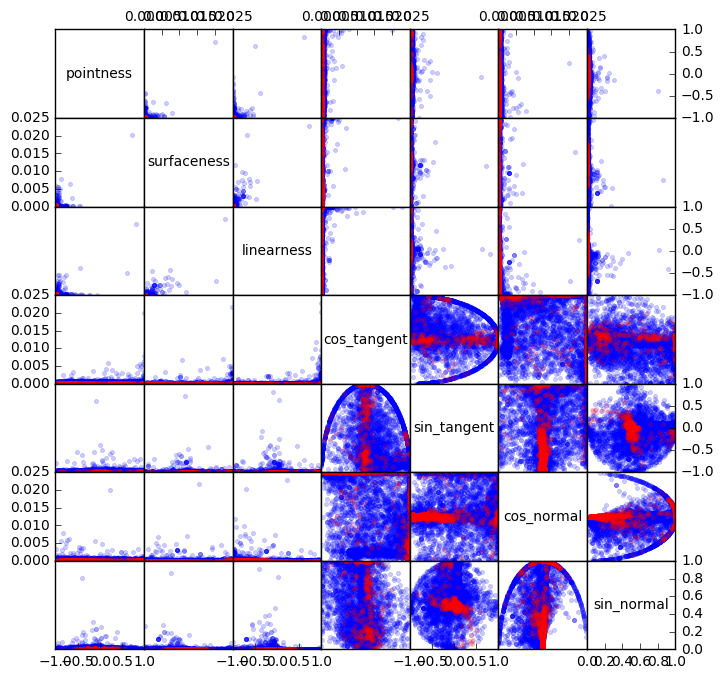

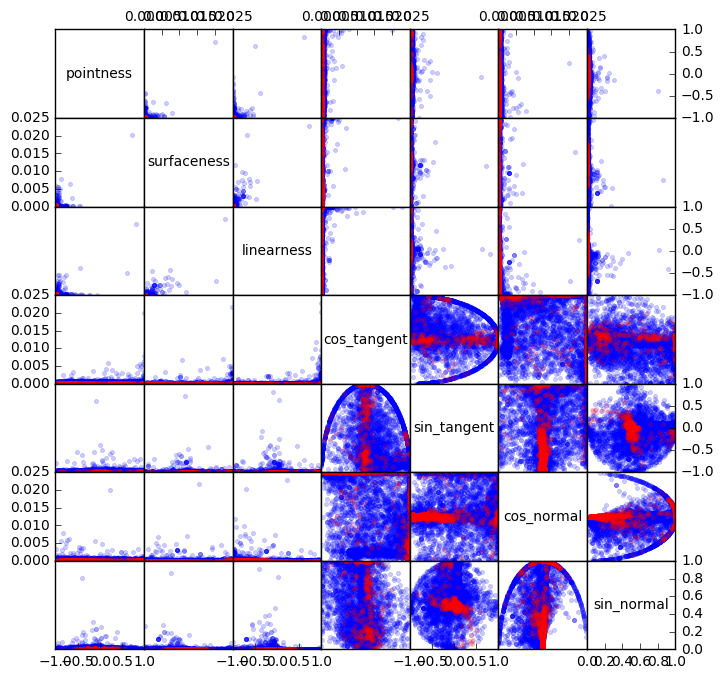

In [9]:
print '\n\nScatter Matrix for Classes. Target Points in Red'
scatterplot_matrix_classId(data[data['class_id']==0][data.columns[:-1]], 
                           data[data['class_id']==1][data.columns[:-1]], loglog=False, alpha=0.2)


Looking at the above scatter plot, the pipe-like points (shown in red) and other points (shown in blue) are clustered together. This is a good sign for classification. Some features pairs such as (linearness, cos_tangent) and (cos_normal, sin_normal) seem to have a linear relationship, so are somewhat redundant. This will be explored further below.

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns

In [10]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'class_id'
target_col = 'class_id' 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['pointness', 'surfaceness', 'linearness', 'cos_tangent', 'sin_tangent', 'cos_normal', 'sin_normal']

Target column: class_id

Feature values:
   pointness  surfaceness  linearness  cos_tangent  sin_tangent  cos_normal  \
0   0.000134     0.000313    0.000084     0.218129     0.155868    0.988950   
1   0.000157     0.000099    0.000151     0.960559     0.082704    0.604203   
2   0.000132     0.000325    0.000411     0.989396    -0.145244    0.743649   
3   0.000142     0.000206    0.000552     0.999021     0.044244    0.354133   
4   0.000102     0.000385    0.000287     0.727925    -0.153911    0.909783   

   sin_normal  
0   -0.148248  
1   -0.183079  
2   -0.265045  
3   -0.119026  
4   -0.415084  


### Scaling the data
Scaling the data to give it a 0 mean and 1 std doesn't help the classifiers. It did increase the performance of SVC (F1 score went from 0 to 0.76), but not so much that it was chosen as the final classifier. The AdaBoostClassifier's (the best) is not impacted by scaling. Therefore, no scaling is used.

                  0             1             2             3             4  \
count  1.622100e+04  1.622100e+04  1.622100e+04  1.622100e+04  1.622100e+04   
mean   5.030123e-16 -4.056821e-17 -4.148535e-17 -1.145857e-16 -8.334373e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00   
min   -3.752318e-01 -4.214344e-01 -1.828756e-01 -7.918614e-01 -3.414320e+00   
25%   -3.493472e-01 -1.128372e-01 -1.675163e-01 -6.725813e-01 -3.830986e-01   
50%   -3.423402e-01 -6.761937e-02 -1.511790e-01 -5.264519e-01 -2.684696e-01   
75%   -3.804978e-02 -2.249865e-03  1.245225e-02  3.579367e-01 -1.078619e-03   
max    6.903078e+01  8.989018e+01  6.085889e+01  2.025557e+00  2.588858e+00   

                  5             6  
count  1.622100e+04  1.622100e+04  
mean  -1.388035e-17  1.509865e-17  
std    1.000031e+00  1.000031e+00  
min   -2.705853e+00 -5.207236e+00  
25%   -3.628716e-01 -2.647423e-01  
50%    5.874333e-01  2.086602e-01  
75%    5.997659e-01  5.180223e-01  


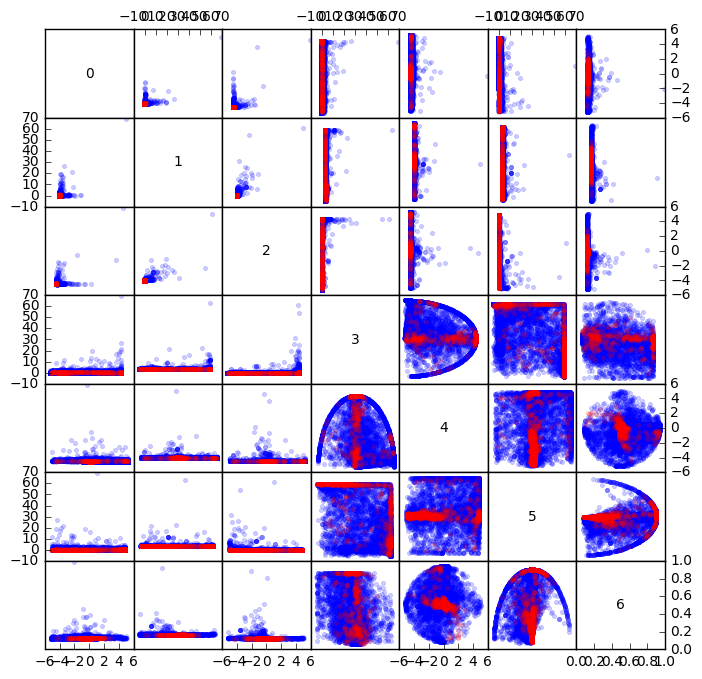

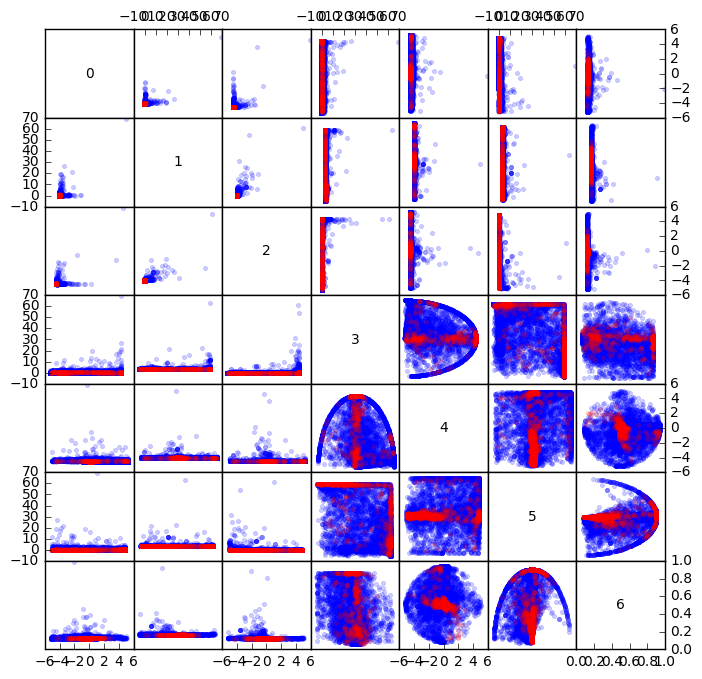

In [29]:
from sklearn import preprocessing

X_scaled = pd.DataFrame(preprocessing.scale(X_all))

print X_scaled.describe()
scatterplot_matrix_classId(X_scaled[y_all==0], X_scaled[y_all==1], filter_percentile=False, alpha=0.2)

#Scaling data isn't helping.
X_scaled = X_all


### PCA Dimensionality reduction

PCA Explained Variance Cumulative Sum
[  54.33796407   85.33291196   94.17211562   99.99765178   99.99983185
   99.99998489  100.        ]


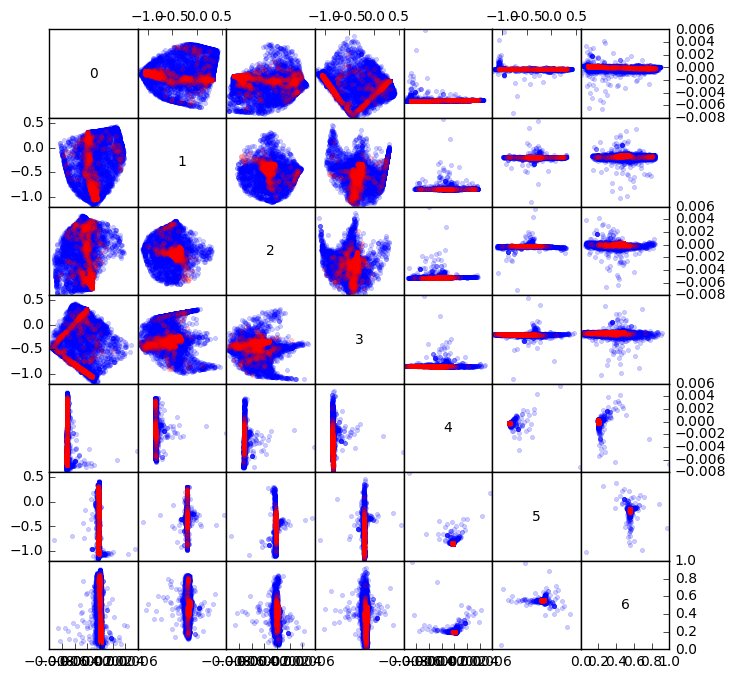

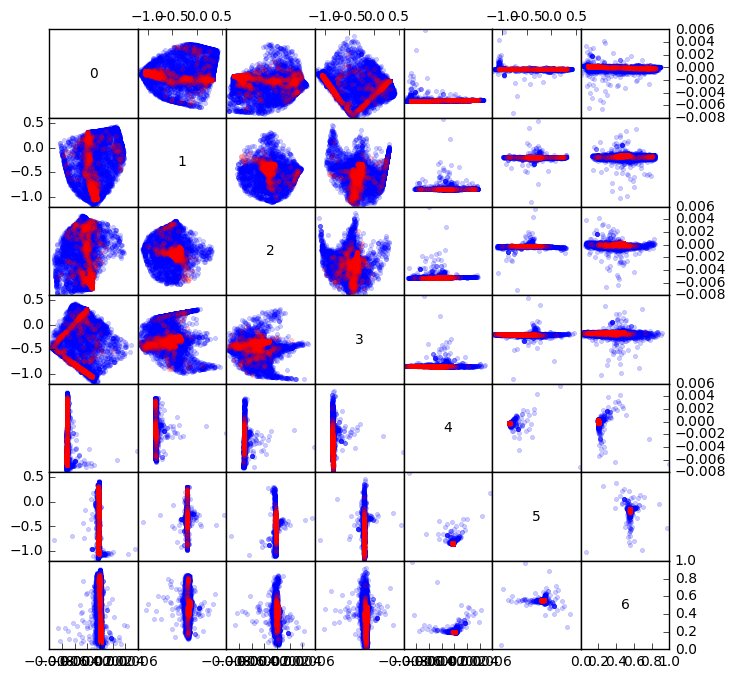

In [12]:
# Try PCA decomposition
X_class1 = X_all[y_all==1]
X_class0 = X_all[y_all==0]

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_all)

print 'PCA Explained Variance Cumulative Sum'
print np.cumsum(pca.explained_variance_ratio_*100)

# pca = PCA(n_components = 3)
# pca.fit(X_all)

a = pca.transform(X_class1)
b = pca.transform(X_class0)

a_data = pd.DataFrame(a)
b_data = pd.DataFrame(b)

plt.figure()
scatterplot_matrix_classId(b_data, a_data, loglog=False, alpha=0.2)


Looking at the PCA, 94% of the data's variance is explained by the first 3 eigen vectors. This verifies that there is a linear relationship between much of the data. This verifies what we saw in the scatter plot of the raw data. However, if PCA is applied to the training data, the resulting classification performance drops from an F1 score of ~90 to ~70. Also, applying a logarithm transform to the data hurt results as well. Therefore, for the remainder of the analysis, just the raw input data is used in classification.

### Implementation: Training and Testing Data Split
For training and testing, the data will be split into a training set of 75% of the data and test set of 25%. The training data is stored in X_train (features), y_train (class). The test data is stored in X_test and y_test.


In [30]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test , y_train, y_test = train_test_split(X_scaled, y_all, train_size = 0.75, random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 12165 samples.
Testing set has 4056 samples.


## Training and Evaluating Models


In [14]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

## Benchmark
To compare the performance of the classifier, I will benchmark it with a simple logistic regression model. Logistic regression tries to fit a linear model to the classified data. With logistic regression, the probability of the classification outcome is modeled using a sigmoid function of the input features. It is a simple model with fast evaluation time.

In [15]:
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn import grid_search

benchmark_clf = linear_model.LogisticRegression(random_state=42)

f1_scorer = make_scorer(f1_score, pos_label=1)
parameters = {'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag'], 'fit_intercept': [True, False]}
benchmark_grid_obj = grid_search.GridSearchCV(benchmark_clf, parameters, f1_scorer)

benchmark_grid_obj = benchmark_grid_obj.fit(X_train, y_train)

benchmark_clf = benchmark_grid_obj.best_estimator_

print 'BENCHMARK'
print 'Benchmark Best Classifier Parameters: ', benchmark_clf.get_params()

print "Benchmark model has a training F1 score of {:.4f}.".format(predict_labels(benchmark_clf, X_train, y_train))
print "Benchmark model has a testing F1 score of {:.4f}.".format(predict_labels(benchmark_clf, X_test, y_test))


BENCHMARK
Benchmark Best Classifier Parameters:  {'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 42, 'dual': False, 'tol': 0.0001, 'solver': 'newton-cg', 'class_weight': None}
Made predictions in 0.0010 seconds.
Benchmark model has a training F1 score of 0.7506.
Made predictions in 0.0010 seconds.
Benchmark model has a testing F1 score of 0.7311.


### Implementation: Algorithm Performance


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


clf_A = AdaBoostClassifier(random_state=42)
clf_B = KNeighborsClassifier()
clf_C = SVC(random_state=42)
clf_D = GaussianNB()

X_train_100 = X_train[:][:100]
y_train_100 = y_train[:][:100]

X_train_200 = X_train[:][:200]
y_train_200 = y_train[:][:200]

X_train_300 = X_train[:][:300]
y_train_300 = y_train[:][:300]

print 'Classifier A:===='
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier B:===='
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier C:===='
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier D:===='
train_predict(clf_D, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_D, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_D, X_train_300, y_train_300, X_test, y_test)



Classifier A:====
Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.1000 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0320 seconds.
F1 score for test set: 0.7707.
Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.0840 seconds
Made predictions in 0.0160 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0310 seconds.
F1 score for test set: 0.7200.
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.0690 seconds
Made predictions in 0.0160 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0160 seconds.
F1 score for test set: 0.8450.

Classifier B:====
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0000 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8333.
Made predictions in 0.0250 seconds.
F1 score for test set: 0.7110.
Training 

## Implementation: Tuning the Best Model
The AdaBoostClassifier ended up with the best performance of the bunch. In this section, it is tuned using grid serach over the entire training set (`X_train` and `y_train`) 

In [17]:
from sklearn import grid_search
from sklearn.metrics import make_scorer

# Tuning parameters
parameters = {'n_estimators': [10, 20, 30, 40, 49, 50, 51, 60, 70, 80, 90, 100], 'algorithm':['SAMME', 'SAMME.R']}

clf = AdaBoostClassifier(random_state=42)

f1_scorer = make_scorer(f1_score, pos_label=1)

grid_obj = grid_search.GridSearchCV(clf, parameters, f1_scorer)

grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

print 'Best Classifier Parameters: ', clf.get_params()

print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Best Classifier Parameters:  {'n_estimators': 50, 'base_estimator': None, 'random_state': 42, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
Made predictions in 0.0790 seconds.
Tuned model has a training F1 score of 0.9122.
Made predictions in 0.0310 seconds.
Tuned model has a testing F1 score of 0.8957.


In [18]:
import pickle
pickle.dump(clf, open("classifier.p", "wb"))


In [19]:
from mpl_toolkits.mplot3d import Axes3D
def plot_classified_points(classified_point_cloud):
    colors = ['b.','r.','g.','k.','m.']
    fig = plt.gcf()
    for i in range(min(classified_point_cloud['class_id']), max(classified_point_cloud['class_id'])+1):
        class_points = classified_point_cloud.loc[classified_point_cloud['class_id']== i]

        plt.plot(-class_points['y'], class_points['z'], colors[i])


In [20]:
def classify_and_plot_file(clf, point_cloud_file_name):
    data = pc.calculate_point_cloud_features(point_cloud_file_name)
    # Remove the point cloud x,y,z data from the data frame. Those will not be used as features
    point_cloud_points = data[['x','y','z','intensity']]

    del data['x']
    del data['y']
    del data['z']
    del data['intensity']
    
    X_all = data
    predicted_class = clf.predict(X_all)
    
    classified_point_cloud = point_cloud_points[['x','y','z']]
    classified_point_cloud['class_id'] = predicted_class
    classified_point_cloud['intensity'] = predicted_class

    plot_classified_points(classified_point_cloud)

    point_cloud_points = classified_point_cloud[['x','y','z','class_id']]
    return point_cloud_points


## Test Sensitivity
To test the sensitivity of the model to noise, add different levels of noise to the point cloud data and measure its impact on the F1 score. The sensor error is about 0.3cm standard deviation. This is within the zone where the F1 score is behaving well.

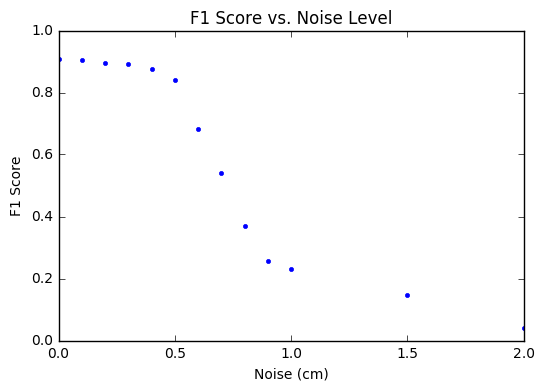

In [64]:
# from scipy import spatial

# noise_levels = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02]
# score = np.zeros(len(noise_levels))
# for i, noise_level in enumerate(noise_levels):
#     point_cloud_sensitivity = np.array(point_cloud_points[['x','y','z']])
#     noise = np.random.randn(point_cloud_sensitivity.shape[0], point_cloud_sensitivity.shape[1]) * noise_level
#     point_cloud_sensitivity += noise

#     kdtree = spatial.cKDTree(point_cloud_sensitivity)

#     data = pc.calculate_features(point_cloud_sensitivity, np.zeros(point_cloud_sensitivity.shape[0]), kdtree)
#     X_sensitivity = data[feature_cols]

#     y_sensitivity = clf.predict(X_sensitivity)
#     score[i] = f1_score(y_all.values, y_sensitivity, pos_label=1)
#     print 'Noise Level = ', noise_level, ' F1 Score = ', score[i]
noise_levels = np.array(noise_levels)
plt.plot(noise_levels*100, score, 'b.')
plt.title('F1 Score vs. Noise Level')
plt.xlabel('Noise (cm)')
plt.ylabel('F1 Score')

# Training Results

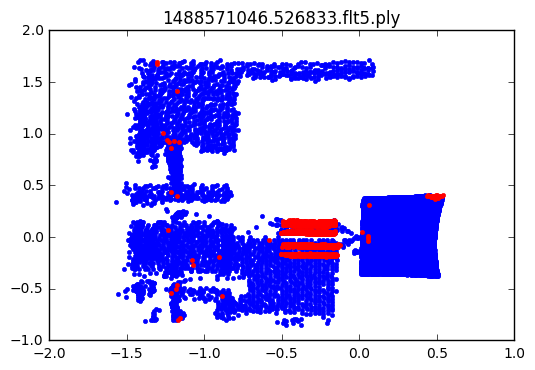

In [53]:
import ply_file as ply
# Plot and output training results
for point_cloud_file_name in point_cloud_file_names:
    plt.figure()
    point_cloud_points = classify_and_plot_file(clf, data_file_path + point_cloud_file_name)
    plt.title(point_cloud_file_name)
    ply.write_ply_file(point_cloud_file_name[:-9]+".trn.ply", np.array(point_cloud_points))

# Test Results

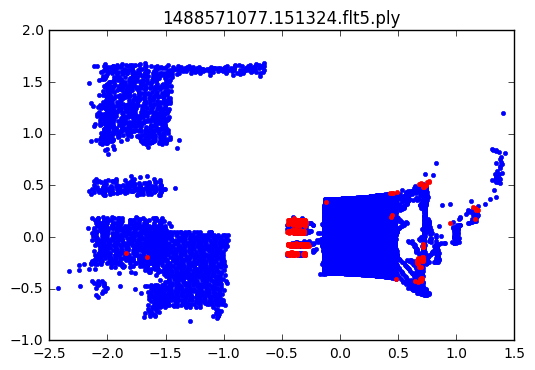

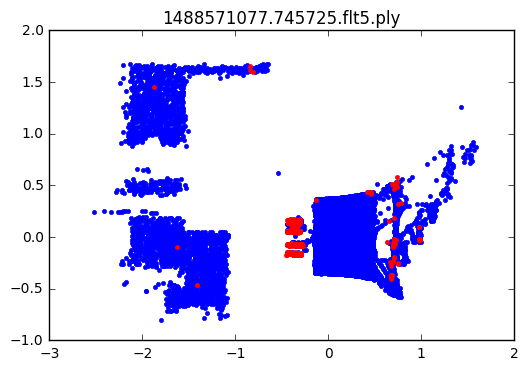

In [68]:
from os import listdir
from os.path import isfile, join
import random
test_file_path = "../data/moving/"
only_files = [f for f in listdir(test_file_path) if isfile(join(test_file_path, f))]
ply_files = [f for f in only_files if f[-9:] == '.flt5.ply']
# Choose 6 test files
random.seed(42)
indices = random.sample(range(len(ply_files)), 6)

indices = [24, 25]
ply_files = [ply_files[index] for index in indices]

for point_cloud_file_name in ply_files:
    plt.figure()
    point_cloud_points = classify_and_plot_file(clf, test_file_path + point_cloud_file_name)
    plt.title(point_cloud_file_name)
    ply.write_ply_file(point_cloud_file_name[:-9] + ".tst.ply", np.array(point_cloud_points))    


In [ ]:
# pc.animate_classifier(test_file_path, "classifier.p")


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.